In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import pandas as pd
import random
import scipy.optimize as opt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

%matplotlib inline

In [2]:
def med_med (true,fitted):
    temp = fitted - true
    return (np.median(np.abs(temp-np.median(temp))))

In [3]:
# Low-pass filter to smooth out the noise

def low_pass_filter(y, box_pts, mode='same', base=1):
    box = base*(np.ones(box_pts)/box_pts)
    y_filtered = np.convolve(y, box, mode=mode)
    if mode=='same':
        y_filtered[0:int(box_pts/2)]=y_filtered[int(box_pts/2)]
        y_filtered[len(y_filtered)-int(box_pts/2):len(y_filtered)]=y_filtered[len(y_filtered)-int(box_pts/2)]
    return y_filtered

In [4]:
def calc_chisq(lightcurve,fx):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / fx).sum()
    
    return chisq

In [5]:
def calc_chisq2(lightcurve,fx,ferror):
    """Function to calculate the chi squared of the fit of the lightcurve
    data to the function provided"""
    
    chisq = ((lightcurve - fx)**2 / (ferror**2)).sum()
    
    return chisq

In [6]:
# ASSUMPTION = t and m are panda dataframes
# Create a function that: 
# 1- Smoothes the lightcurve
# 2- Divides it into bins of arbitrary sizes
# 3- Calculates (m - mean)/std(m)
# 4- Counts the number of outliers in each bin with deviations larger than threshold*sigma

def find_peaks (t, m, smooth='yes', bin_size = 30, threshold = 3):
    
    if smooth == 'yes':
        m = low_pass_filter(m,8)
    else:
        pass
    
    bins = np.linspace(t.min(),t.max(),int((t.max()-t.min())/bin_size))
    groups = df.groupby(np.digitize(t, bins))
    
    std_ = np.std(m)
    delta_m = []
    t__ = []
    c=0
    for i in groups.indices:
        #print c
        c = c+1
        #print i
        m_ = m[groups.indices[i]]
        t_ = t[groups.indices[i]]
        #print t,m
        del_m = np.asarray((np.abs(m_- m_.mean())/std_))
        delta_m.append(del_m)
        t__.append(np.asarray(t_))
        
    n_outliers = []
    t_mean_in_each_bin = []
    for j in range(len(delta_m)):
    
        n_outliers.append(len(np.where(delta_m[j]>threshold)[0])) 
        t_mean_in_each_bin.append(np.mean(t__[j]))
        
    return n_outliers, t_mean_in_each_bin

In [7]:
# An example baseline for creating a tophat function

xt = np.linspace(-1,2,100)

In [8]:
home = os.path.expanduser("~")

In [ ]:
direc = os.listdir(home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/lc')

In [9]:
# Path to the larger dataset
home = os.path.expanduser("~")

temp = home+'/Library/Mobile Documents/com~apple~CloudDocs/Microlensing_Data_Challeng/data-challenge-1/alldclc/'#lc/'
direc = os.listdir(temp)

In [10]:
'''
Defining the tophat function, a function that has a constant baseline 
except for a short interval at which it has another constant value
# x is the time baseline
# t0 is the time of the center of the tophat
# tE is half of the duration of the tophat
# am is the amplitude of the tophat
'''
def rect1(x,t0, tE, am):
    '''
    x  = time array
    t0 = time of center of the top-hat
    tE = half duration of the top-hat
    am = amplitude
    '''
    x0 = x - t0
    return am*np.where(np.abs(x0)<=tE, 1, 0)






def sinusoid(x, amp, off,P):
    '''
    amp = amplitude
    off = offset
    '''
    x0 = (x-off)
    return amp*np.sin(x0)


def trapezoid(x, a, b, tau1, tau2, tau3, tau4):
    # a and c are slopes
    #tau1 and tau2 mark the beginning and end of the flat top
#     y = np.zeros(len(x))
#     c = -np.abs(c)
#     a = np.abs(a)
#     #(tau1,tau2) = (min(tau1,tau2),max(tau1,tau2))
#     y[:int(tau1)] = base
#     y[int(tau1):int(tau2)] =  a*x[:int(tau1)] + b
#     y[int(tau2):int(tau3)] =  a*tau1 + b 
#     y[int(tau2):int(tau4)] = c*(x[int(tau2):]-tau2) + (a*tau1 + b)
#     y[int(tau4):] = base

    y = np.zeros(len(x))
    df_trap = pd.DataFrame({'x': x, 'y': y})
    
    c1 = np.abs((b-a)/(tau2-tau1))
    c2 = -1 * np.abs((a-b)/(tau4-tau3))
    
    df_trap['y'][df_trap['x']<tau1] = a
    df_trap['y'][(df_trap['x']>tau1) & (df_trap['x']<tau2)] =  c1*df_trap['x'][(df_trap['x']>tau1) & (df_trap['x']<tau2)] + (a- c1 * tau1)
    df_trap['y'][(df_trap['x']>tau2) & (df_trap['x']<tau3)] =  b
    df_trap['y'][(df_trap['x']>tau3) & (df_trap['x']<tau4)] = c2*df_trap['x'][(df_trap['x']>tau3) & (df_trap['x']<tau4)] + (a- c2 * tau4)
    df_trap['y'][df_trap['x']>tau4] = a

    return df_trap['y']

# calculating the likelihood function

def lnlike(theta, t, f, f_err):
    t0, tE, amp  = theta
    model = rect1(t,t0, tE,amp)
    inv_sigma2 = 1.0/(f_err**2)
    return -0.5*(np.sum((f-model)**2*inv_sigma2))




In [12]:
def localize_event(lightcurve,t0,tE):
    """Function to estimate roughly the area around the peak of an event, 
    and identify which timestamps in the array belong to the event versus
    the baseline
    """
    
    idx1 = np.where(lightcurve >= t0-tE)[0]
    idx2 = np.where(lightcurve <= t0+tE)[0]
    event = list(set(idx1).intersection(set(idx2)))
    
    baseline = np.arange(0,len(lightcurve),1)
    baseline = np.delete(baseline,event)
    
    it0 = np.where(lightcurve == t0)[0][0]
    
    #print min(lightcurve)
    #print it0
    return baseline, event, it0

In [13]:
def prepare(t,m,err):
    
    df = pd.DataFrame({'t': t, 'magnitude': m, 'm_err': err})
    peaks = np.array([t[np.argmin(m)]])
    baseline, event, it0 = localize_event(df['t'], peaks[0],50)
    
    base_mag = np.median(df['magnitude'][baseline])
    df['A'] = 10 ** (0.4*(base_mag - df['magnitude']))
    
    interpol = interp1d(df['t'],df['A'], kind='cubic')
    dt = np.abs(df['t'][np.argmin(np.abs(interpol(df['t'])-1.06))]-peaks[0])
    #print dt
    
    if dt==0.0:
        dt = 50


        
    
    #dt = 50
    baseline, event, it0 = localize_event(df['t'], peaks[0],dt)

    while (np.abs((df['t'][event]).diff())).max() > 0.1:
        
        if dt>20:
            dt = dt - 10
            baseline, event, it0 = localize_event(df['t'], peaks[0],dt)
        else:
            break
    #print dt    
    return df, interpol,baseline, event, it0, dt





(0, 4)

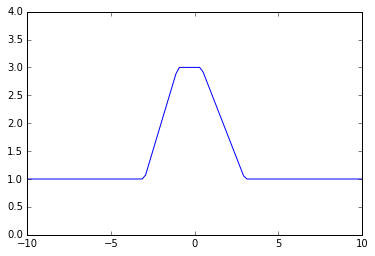

In [15]:
# example of the trapezoid function

x = np.linspace(-10,10,100)
y = trapezoid(x, 1, 3,-3,-1,0.4,3 )
plt.plot(x,y)
plt.xlim(-10,10)
plt.ylim(0,4)

(-0.5, 2.5)

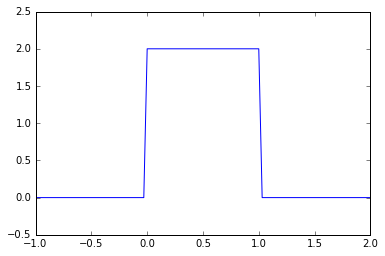

In [17]:
# example of the tophat function

xt = np.linspace(-1,2,100)
yt = rect1(xt, 0.5, 0.5,2)
plt.plot(xt,yt)
plt.xlim(-1,2)
plt.ylim(-0.5,2.5)

0.5


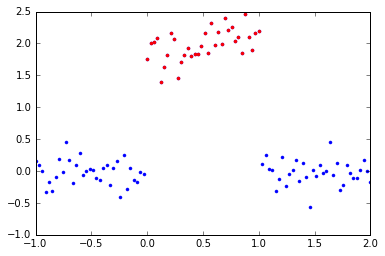

In [18]:
# Adding noise to the example tophat function

xdata = xt
yerror = np.random.normal(0.0, 0.2, len(yt))
ydata = yt + yerror

#ydata = low_pass_filter(ydata,10)

plt.plot(xdata, ydata, 'b.')
plt.plot(xdata[ydata>1*np.std(ydata)], ydata[ydata>1*np.std(ydata)], 'r.')
print np.median(xdata[ydata>1*np.std(ydata)])

0 2.3965083879974927 0.27272727272727315 0.4848484848484851 0.909090909090909 1.1212121212121209
[-0.01978196  1.98470341 -0.01487412 -0.01164961  1.0065212   1.02036512]


/Users/Research/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/scipy/optimize/minpack.py:787: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


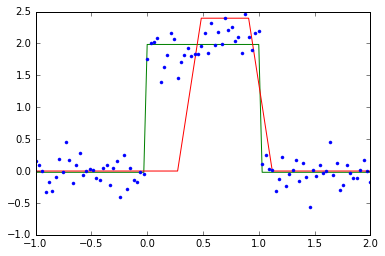

In [19]:
# Fitting a trapezoid function

t0_ini = xdata[np.argmax(ydata[ydata <np.percentile(ydata,[0,99.95] )[1]])]
tE_ini = 0.5*(xdata[1]-xdata[0])*len(np.where(abs(ydata-np.median(ydata))>2*np.std(ydata))[0])
am_ini = np.max(ydata[ydata <np.percentile(ydata,[0,99.95] )[1]]) 

a, b, tau1, tau2, tau3, tau4 = 0, am_ini, t0_ini-2*tE_ini, t0_ini-1*tE_ini, t0_ini+1*tE_ini, t0_ini+2*tE_ini

print a, b, tau1, tau2, tau3, tau4


paramt = [a, b, tau1, tau2, tau3, tau4]

# optmizing
popt, pcov = opt.curve_fit(trapezoid, xdata, ydata, p0=paramt)

guess    = trapezoid(xdata, *paramt)
solution = trapezoid(xdata, *popt)

print popt 

plt.figure()
plt.plot(xt, solution,'g')
plt.plot(xt, guess,'r')
plt.plot(xt, ydata, 'b.')

0.5 0.5151515151515147 2.4630154281769476


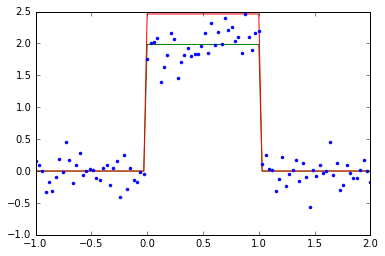

In [20]:
# give p0 [t0, tE, am]

t0_ini = np.median(xdata[ydata>1*np.std(ydata)])#xdata[np.argmax(ydata)]
tE_ini = 0.5*(xt[1]-xt[0])*len(np.where(abs(ydata-np.median(ydata))>1*np.std(ydata))[0])
am_ini = np.max(ydata)

print t0_ini,tE_ini,am_ini


paramt = [t0_ini, tE_ini, am_ini]

# optmizing
popt, pcov = opt.curve_fit(rect1, xdata, ydata, p0=paramt)

guess    = rect1(xdata, *paramt)
solution = rect1(xdata, *popt)

plt.figure()
plt.plot(xt, solution,'g')
plt.plot(xt, guess,'r')
plt.plot(xt, ydata, 'b.')